In [70]:
import pandas as pd
import sklearn
import bnlearn as bn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [71]:
df = pd.read_csv("./heart.csv")
drop_list = ['Age', 'RestingBP', 'MaxHR']
df = df.drop(columns=drop_list)
df.head()

,Sex,ChestPainType,Cholesterol,FastingBS,RestingECG,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,M,ATA,289,0,Normal,N,0.0,Up,0
1,F,NAP,180,0,Normal,N,1.0,Flat,1
2,M,ATA,283,0,ST,N,0.0,Up,0
3,F,ASY,214,0,Normal,Y,1.5,Flat,1
4,M,NAP,195,0,Normal,N,0.0,Up,0


In [72]:
dfhot_train, dfnum_train = bn.df2onehot(df)


[df2onehot] >Auto detecting dtypes.


100%|██████████| 9/9 [00:00<00:00, 83.05it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 9/9 [00:00<00:00, 122.09it/s]

[df2onehot] >Total onehot features: 22


In [73]:
dfnum_train

,Sex,ChestPainType,Cholesterol,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
0,1,2,0,0,2,0,3,0
1,0,3,0,0,2,0,2,1
2,1,2,0,0,3,0,3,0
3,0,1,0,0,2,1,2,1
4,1,3,0,0,2,0,3,0
...,...,...,...,...,...,...,...,...
913,1,4,0,0,2,0,2,1
914,1,1,0,1,2,0,2,1
915,1,1,0,0,2,1,2,1
916,0,2,0,0,1,0,2,1


In [74]:
dfnum_target = dfnum_train.pop('HeartDisease')
dfnum_target

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

In [75]:
Xtrain, Xval, Ztrain, Zval = train_test_split(dfnum_train, dfnum_target, test_size=0.2, random_state=0)
valid = pd.concat([Xval, Zval], axis='columns')
dfnum = pd.concat([Xtrain, Ztrain], axis='columns')
dfnum

,Sex,ChestPainType,Cholesterol,FastingBS,RestingECG,ExerciseAngina,ST_Slope,HeartDisease
378,1,1,1,1,2,1,2,1
356,1,1,1,0,2,1,2,1
738,0,3,0,0,1,0,3,0
85,1,1,0,0,2,1,2,1
427,1,1,1,0,3,1,2,1
...,...,...,...,...,...,...,...,...
835,1,1,0,0,2,1,2,1
192,1,2,0,0,2,0,3,0
629,0,1,0,0,1,0,3,0
559,1,1,0,0,2,1,1,1


[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]


[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


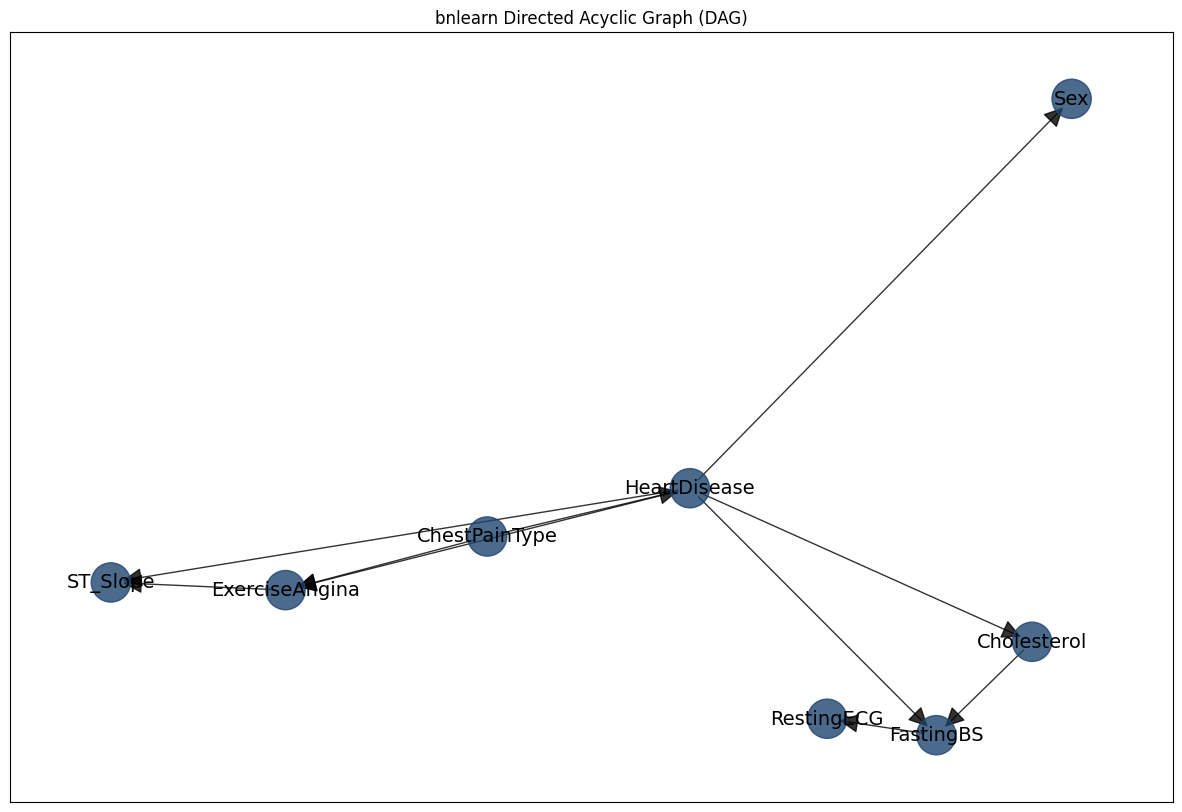

In [76]:
# Structure learning
DAG = bn.structure_learning.fit(dfnum, methodtype='hc', root_node='Survived', bw_list_method='nodes', verbose=3)

# Plot
G = bn.plot(DAG)

In [77]:
model = bn.parameter_learning.fit(DAG, dfnum, verbose=3);

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of ChestPainType:
+------------------+----------+
| ChestPainType(1) | 0.369666 |
+------------------+----------+
| ChestPainType(2) | 0.227797 |
+------------------+----------+
| ChestPainType(3) | 0.237601 |
+------------------+----------+
| ChestPainType(4) | 0.164937 |
+------------------+----------+
[bnlearn] >CPD of ExerciseAngina:
+-------------------+-----+---------------------+
| ChestPainType     | ... | ChestPainType(4)    |
+-------------------+-----+---------------------+
| HeartDisease      | ... | HeartDisease(1)     |
+-------------------+-----+---------------------+
| ExerciseAngina(0) | ... | 0.548951048951049   |
+-------------------+-----+---------------------+
| ExerciseAngina(1) | ... | 0.45104895104895104 |
+-------------------+-----+---------------------+
[

In [78]:
# function Accuracy
def get_acc(model, df, col):
    # Get accuracy score by the model for the validation dataset df with target col
    pred = bn.predict(model, df, variables=[col])
    print(pred)
    acc = accuracy_score(df[col], pred[col])
    print('Accuracy -', acc)
    return acc

In [79]:
acc1 = get_acc(model, valid, 'HeartDisease')

[bnlearn]> Remaining columns for inference: 7


  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [00:00<00:00, 243.16it/s]

     HeartDisease         p
0               1  0.872518
1               1  0.707089
2               1  0.872518
3               1  0.761907
4               0  0.849235
..            ...       ...
179             1  0.741374
180             1  0.892802
181             0  0.640592
182             0  0.849235
183             1  0.835539

[184 rows x 2 columns]
Accuracy - 0.8369565217391305
